In [1]:
from comet import COMET
from models.encoder import FTClassifier
# import datautils
from tasks.fine_tuning import finetune_fit
from tasks.fine_tuning import finetune_predict
from tasks.linear_evaluation import eval_classification
from dataloading.ptb_preprocessing import load_ptb
from config_files.PTB_Configs import Config as Configs

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from tqdm import tqdm
from utils import plot_channels
from utils import process_batch_ts
from utils import split_data_label
from utils import start_logging
from utils import stop_logging
from utils import seed_everything

from datetime import datetime

In [2]:
configs = Configs()
RANDOM_SEED = configs.RANDOM_SEED

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Specify saving and logging directory

In [3]:
working_directory = configs.working_directory
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = configs.logging_directory
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

In [4]:
test = np.load("../MCP/chapman/label/label.npy")
test

array([[   1,    1],
       [   0,    2],
       [   3,    3],
       ...,
       [   2, 9711],
       [   2, 9712],
       [   2, 9713]])

In [5]:
def segment(X, y, sample):
    '''
    segment the trial to non-overlapping samples
    '''
    length = X.shape[1]
    assert length % sample == 0
    nsample = length / sample
    
    samples = X.reshape(-1, sample, X.shape[-1])
    tids = np.repeat(np.arange(y.shape[0])+1, nsample)
    labels = np.repeat(y, nsample, axis=0)
    labels = np.hstack([labels, tids.reshape(labels.shape[0], -1)])
    return samples, labels

In [6]:
def load_chapman(root='data/chapman', split=None):
    data_path = os.path.join(root, 'feature')
    label_path = os.path.join(root, 'label', 'label.npy')
    
    labels = np.load(label_path)
    
    pids_sb = list(labels[np.where(labels[:, 0]==0)][:, 1])
    pids_af = list(labels[np.where(labels[:, 0]==1)][:, 1])
    pids_gsvt = list(labels[np.where(labels[:, 0]==2)][:, 1])
    pids_sr = list(labels[np.where(labels[:, 0]==3)][:, 1])
    
    train_ids = pids_sb[:-500] + pids_af[:-500] + pids_gsvt[:-500] + pids_sr[:-500]
    valid_ids = pids_sb[-500:-250] + pids_af[-500:-250] + pids_gsvt[-500:-250] + pids_sr[-500:-250]
    test_ids = pids_sb[-250:] + pids_af[-250:] + pids_gsvt[-250:] + pids_sr[-250:]
    
    filenames = []
    for fn in os.listdir(data_path):
        filenames.append(fn)
    filenames.sort()
    
    train_trials = []
    train_labels = []
    valid_trials = []
    valid_labels = []
    test_trials = []
    test_labels = []
    
    for i, fn in enumerate(tqdm(filenames)):
        label = labels[i]
        feature = np.load(os.path.join(data_path, fn))
        for trial in feature:
            if i+1 in train_ids:
                train_trials.append(trial)
                train_labels.append(label)
            elif i+1 in valid_ids:
                valid_trials.append(trial)
                valid_labels.append(label)
            elif i+1 in test_ids:
                test_trials.append(trial)
                test_labels.append(label)
                
    X_train = np.array(train_trials)
    X_val = np.array(valid_trials)
    X_test = np.array(test_trials)
    y_train = np.array(train_labels)
    y_val = np.array(valid_labels)
    y_test = np.array(test_labels)
        
    if split:
        X_train, y_train = segment(X_train, y_train, split)
        X_val, y_val = segment(X_val, y_val, split)
        X_test, y_test = segment(X_test, y_test, split)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = load_chapman(root='../MCP/chapman', split=300)

100%|██████████| 9713/9713 [00:06<00:00, 1460.64it/s]


#### Load and preprocessing data

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(82434, 300, 12)
(12642, 300, 12)
(13290, 300, 12)
(82434, 3)
(12642, 3)
(13290, 3)


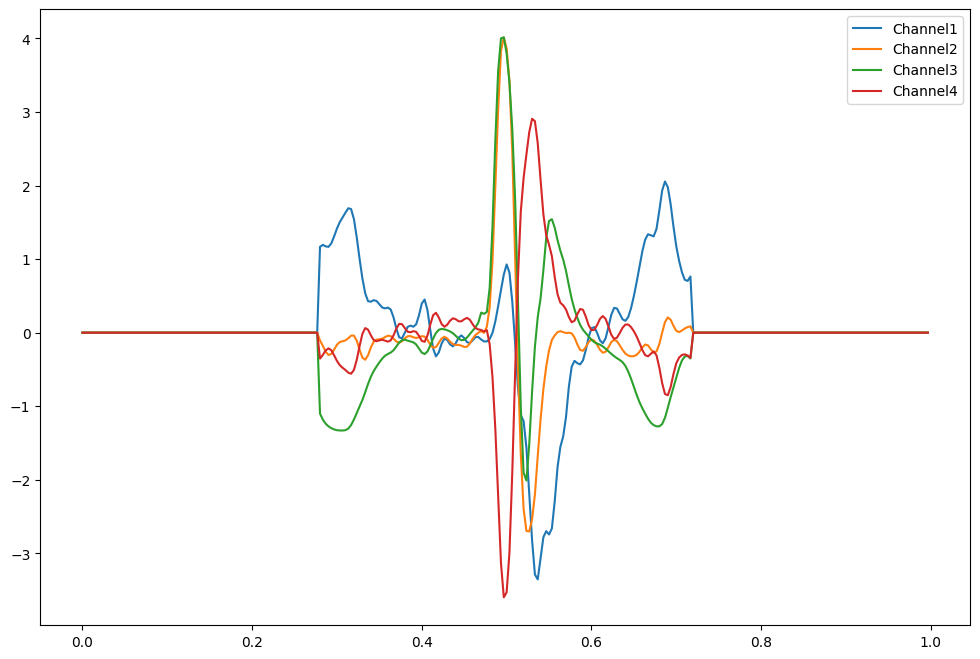

In [9]:
# plot first sample, first four channels
plot_channels(1, X_train[0][:,:4])

## Train model

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The program will run on {device}!")

The program will run on cuda!


### Callback functions

In [11]:
def pretrain_callback(model, loss):
    n = model.n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, X_train, y_train[:, 0], X_val, y_val[:, 0], fraction=1)
        print(metrics_dict)
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [12]:
def finetune_callback(model, f1, fraction=1.0):
    n = model.n_epochs
    if model.n_epochs == 1:
        model.finetune_f1 = f1
        torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    # control the saving frequency
    if n % 1 == 0:
        if f1 > model.finetune_f1:
            model.finetune_f1 = f1
            torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    return finetune_callback

## Self-Supervised

In [13]:
start_time = datetime.now()
# Train a COMET model
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=12,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    flag_use_multi_gpu=configs.flag_use_multi_gpu,
    after_epoch_callback=pretrain_callback,
)

epoch_loss_list, epoch_f1_list = model.fit(
    X_train,
    y_train,
    shuffle_function = configs.shuffle_function,
    verbose=configs.verbose,
    n_epochs=configs.n_epochs,
    masks = configs.masks,
    factors = configs.factors
)

end_time = datetime.now()
print(f'Duration: {end_time - start_time}')

100%|██████████| 323/323 [02:08<00:00,  2.51it/s]


Epoch #1: loss=7.452660005769612
{'Accuracy': 0.5726150925486474, 'Precision': 0.5954404615089931, 'Recall': 0.5961305166490775, 'F1': 0.5781744935599654, 'AUROC': np.float64(0.8327428775333015), 'AUPRC': np.float64(0.6126061979768325)}


100%|██████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch #2: loss=6.313684622446696
{'Accuracy': 0.5644676475241259, 'Precision': 0.5902042605677944, 'Recall': 0.5878342955600719, 'F1': 0.5706146854435522, 'AUROC': np.float64(0.8319590255753666), 'AUPRC': np.float64(0.614726740526565)}


100%|██████████| 323/323 [02:13<00:00,  2.42it/s]


Epoch #3: loss=6.056722635104332
{'Accuracy': 0.5719822812846068, 'Precision': 0.6028206470406066, 'Recall': 0.6004845882488429, 'F1': 0.5848893365162953, 'AUROC': np.float64(0.8387963383987352), 'AUPRC': np.float64(0.6353061242687841)}


100%|██████████| 323/323 [02:18<00:00,  2.33it/s]


Epoch #4: loss=5.888727941630799
{'Accuracy': 0.5830564784053156, 'Precision': 0.6206315606145433, 'Recall': 0.6180221758349027, 'F1': 0.6024853529742175, 'AUROC': np.float64(0.8485487144299829), 'AUPRC': np.float64(0.6650129968338448)}


100%|██████████| 323/323 [02:12<00:00,  2.44it/s]


Epoch #5: loss=5.757738915490515
{'Accuracy': 0.5946052839740548, 'Precision': 0.6424042468415638, 'Recall': 0.6368551989865242, 'F1': 0.622749227291399, 'AUROC': np.float64(0.8552350670409642), 'AUPRC': np.float64(0.6879612551425764)}


100%|██████████| 323/323 [02:04<00:00,  2.58it/s]


Epoch #6: loss=5.6487278585080745
{'Accuracy': 0.6008542952064547, 'Precision': 0.6524122820848458, 'Recall': 0.645693489660724, 'F1': 0.6319540213979833, 'AUROC': np.float64(0.8601999623670495), 'AUPRC': np.float64(0.702993291799577)}


100%|██████████| 323/323 [02:13<00:00,  2.43it/s]


Epoch #7: loss=5.552342153625724
{'Accuracy': 0.6154880556873913, 'Precision': 0.6707773719078465, 'Recall': 0.6658227619515644, 'F1': 0.6514115793398113, 'AUROC': np.float64(0.8631225212015171), 'AUPRC': np.float64(0.7113672151748399)}


100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch #8: loss=5.465049391175493
{'Accuracy': 0.6186521120075937, 'Precision': 0.6792538166282895, 'Recall': 0.6737449633976265, 'F1': 0.6590770757950631, 'AUROC': np.float64(0.8646547813958503), 'AUPRC': np.float64(0.7154888679169853)}


100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch #9: loss=5.384258847177764
{'Accuracy': 0.6167536782154722, 'Precision': 0.6796419359533743, 'Recall': 0.6757663900287684, 'F1': 0.6589258839550114, 'AUROC': np.float64(0.8662837101235431), 'AUPRC': np.float64(0.7180990248206883)}


100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch #10: loss=5.307023408236327
{'Accuracy': 0.6193640246796392, 'Precision': 0.6834157720577622, 'Recall': 0.6802100349655412, 'F1': 0.6624991527830921, 'AUROC': np.float64(0.8677305074922247), 'AUPRC': np.float64(0.7204471537474539)}


100%|██████████| 323/323 [02:19<00:00,  2.31it/s]


Epoch #11: loss=5.236122494126543
{'Accuracy': 0.6192058218636292, 'Precision': 0.684391608625667, 'Recall': 0.6816293876961281, 'F1': 0.6633561545822801, 'AUROC': np.float64(0.8690276651779523), 'AUPRC': np.float64(0.7228873478861502)}


100%|██████████| 323/323 [02:04<00:00,  2.59it/s]


Epoch #12: loss=5.180867256205759
{'Accuracy': 0.6182566049675684, 'Precision': 0.6852019051340594, 'Recall': 0.6833814083336507, 'F1': 0.6640162996848005, 'AUROC': np.float64(0.8704414016014625), 'AUPRC': np.float64(0.725401745611931)}


100%|██████████| 323/323 [02:03<00:00,  2.62it/s]


Epoch #13: loss=5.127490923728472
{'Accuracy': 0.6194431260876444, 'Precision': 0.6868191810728645, 'Recall': 0.6860164931219318, 'F1': 0.665943953603838, 'AUROC': np.float64(0.8721664914152536), 'AUPRC': np.float64(0.7282359321706853)}


100%|██████████| 323/323 [02:06<00:00,  2.55it/s]


Epoch #14: loss=5.075611150559084
{'Accuracy': 0.6242683119759532, 'Precision': 0.6903815993855851, 'Recall': 0.690762756954892, 'F1': 0.6702476736074268, 'AUROC': np.float64(0.874263231205666), 'AUPRC': np.float64(0.7316028887777805)}


100%|██████████| 323/323 [02:18<00:00,  2.33it/s]


Epoch #15: loss=5.028113605799498
{'Accuracy': 0.6295681063122923, 'Precision': 0.692028763060047, 'Recall': 0.6950249394553993, 'F1': 0.67422212909526, 'AUROC': np.float64(0.8764326405414555), 'AUPRC': np.float64(0.7353750248119457)}


100%|██████████| 323/323 [02:17<00:00,  2.35it/s]


Epoch #16: loss=4.986176036022328
{'Accuracy': 0.6328112640404999, 'Precision': 0.6939990007141114, 'Recall': 0.6976755630747072, 'F1': 0.6769514022917328, 'AUROC': np.float64(0.8784117682232692), 'AUPRC': np.float64(0.7387717302358596)}


100%|██████████| 323/323 [02:07<00:00,  2.53it/s]


Epoch #17: loss=4.949248390433229
{'Accuracy': 0.6370036386647683, 'Precision': 0.696957265827238, 'Recall': 0.7013946438547363, 'F1': 0.6814154205712594, 'AUROC': np.float64(0.8803440663758508), 'AUPRC': np.float64(0.7422164437643838)}


100%|██████████| 323/323 [02:04<00:00,  2.60it/s]


Epoch #18: loss=4.91459361197036
{'Accuracy': 0.6386647682328745, 'Precision': 0.6977413875861551, 'Recall': 0.7029045015641705, 'F1': 0.6830615252098342, 'AUROC': np.float64(0.8820265860250511), 'AUPRC': np.float64(0.7452948669324027)}


100%|██████████| 323/323 [02:04<00:00,  2.59it/s]


Epoch #19: loss=4.880489462687645
{'Accuracy': 0.6401676949849707, 'Precision': 0.6995458978577296, 'Recall': 0.7054395893884582, 'F1': 0.6854524116280436, 'AUROC': np.float64(0.8830598400167342), 'AUPRC': np.float64(0.7473997963431953)}


100%|██████████| 323/323 [02:19<00:00,  2.32it/s]


Epoch #20: loss=4.847119544759209
{'Accuracy': 0.6415915203290619, 'Precision': 0.7013266521827852, 'Recall': 0.7073077331682766, 'F1': 0.6870256968663288, 'AUROC': np.float64(0.8833843132778716), 'AUPRC': np.float64(0.7485492218100371)}


100%|██████████| 323/323 [02:27<00:00,  2.19it/s]


Epoch #21: loss=4.814762923452589
{'Accuracy': 0.6415915203290619, 'Precision': 0.7005601421892662, 'Recall': 0.7072106225132874, 'F1': 0.6870637873851869, 'AUROC': np.float64(0.8832061735081191), 'AUPRC': np.float64(0.7492004101198557)}


100%|██████████| 323/323 [02:03<00:00,  2.63it/s]


Epoch #22: loss=4.7823167590447415
{'Accuracy': 0.6389811738648948, 'Precision': 0.698105188702197, 'Recall': 0.7058475730798812, 'F1': 0.6851052340995385, 'AUROC': np.float64(0.8825585063175534), 'AUPRC': np.float64(0.7488140470985587)}


100%|██████████| 323/323 [02:02<00:00,  2.63it/s]


Epoch #23: loss=4.750995104695543
{'Accuracy': 0.6358962189526973, 'Precision': 0.6956549262503718, 'Recall': 0.7038280689084513, 'F1': 0.6828855656415713, 'AUROC': np.float64(0.8817077335107562), 'AUPRC': np.float64(0.7476947401652685)}


100%|██████████| 323/323 [02:13<00:00,  2.42it/s]


Epoch #24: loss=4.7169351555683
{'Accuracy': 0.6327321626324949, 'Precision': 0.6937518097830723, 'Recall': 0.701998462196571, 'F1': 0.6811070536764245, 'AUROC': np.float64(0.8809795799095437), 'AUPRC': np.float64(0.7465589026944305)}


100%|██████████| 323/323 [02:04<00:00,  2.60it/s]


Epoch #25: loss=4.6857575045691595
{'Accuracy': 0.633048568264515, 'Precision': 0.6948805833328506, 'Recall': 0.7029458713652552, 'F1': 0.6823623224035501, 'AUROC': np.float64(0.8804758928288834), 'AUPRC': np.float64(0.7454007466192458)}


100%|██████████| 323/323 [02:05<00:00,  2.58it/s]


Epoch #26: loss=4.65872546625726
{'Accuracy': 0.6283024837842114, 'Precision': 0.6913072452819433, 'Recall': 0.7001428736970451, 'F1': 0.6789489539184462, 'AUROC': np.float64(0.8799559447255386), 'AUPRC': np.float64(0.7439813231362638)}


100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch #27: loss=4.630053370087235
{'Accuracy': 0.6271159626641354, 'Precision': 0.6911037237500187, 'Recall': 0.7003770093564498, 'F1': 0.6787595388258357, 'AUROC': np.float64(0.879600638957654), 'AUPRC': np.float64(0.7429521346348931)}


100%|██████████| 323/323 [02:04<00:00,  2.59it/s]


Epoch #28: loss=4.604547342032562
{'Accuracy': 0.627827875336181, 'Precision': 0.6911517780241488, 'Recall': 0.7009955559234885, 'F1': 0.6791235002821832, 'AUROC': np.float64(0.8790787645683114), 'AUPRC': np.float64(0.7418120734767983)}


100%|██████████| 323/323 [02:02<00:00,  2.63it/s]


Epoch #29: loss=4.580902613239524
{'Accuracy': 0.6256921373200443, 'Precision': 0.6896572263627789, 'Recall': 0.6995397001236241, 'F1': 0.6768754494973512, 'AUROC': np.float64(0.8789913371409221), 'AUPRC': np.float64(0.7417510138377116)}


100%|██████████| 323/323 [02:02<00:00,  2.63it/s]


Epoch #30: loss=4.558150117044096
{'Accuracy': 0.6237146021199177, 'Precision': 0.6887831557581964, 'Recall': 0.6988195987119457, 'F1': 0.6752700198470083, 'AUROC': np.float64(0.878895903744506), 'AUPRC': np.float64(0.7418622989097271)}


100%|██████████| 323/323 [02:26<00:00,  2.21it/s]


Epoch #31: loss=4.536408060862694
{'Accuracy': 0.621578864103781, 'Precision': 0.6883448179134817, 'Recall': 0.697400476853046, 'F1': 0.6736062339719875, 'AUROC': np.float64(0.8788123333655158), 'AUPRC': np.float64(0.7418995024603037)}


100%|██████████| 323/323 [02:19<00:00,  2.32it/s]


Epoch #32: loss=4.514390018251207
{'Accuracy': 0.6191267204556241, 'Precision': 0.6876431007000988, 'Recall': 0.6965531340956734, 'F1': 0.6714754682070325, 'AUROC': np.float64(0.8784729303169377), 'AUPRC': np.float64(0.7410692274544308)}


100%|██████████| 323/323 [02:15<00:00,  2.39it/s]


Epoch #33: loss=4.493730223473207
{'Accuracy': 0.6162790697674418, 'Precision': 0.6857703218028829, 'Recall': 0.6954415834158125, 'F1': 0.6689666487499499, 'AUROC': np.float64(0.8777924950457421), 'AUPRC': np.float64(0.7395275075671761)}


100%|██████████| 323/323 [02:01<00:00,  2.65it/s]


Epoch #34: loss=4.48048245318142
{'Accuracy': 0.6135896218952698, 'Precision': 0.6846651209324677, 'Recall': 0.6944709229184849, 'F1': 0.6668596244580889, 'AUROC': np.float64(0.8768990050569238), 'AUPRC': np.float64(0.737154481500034)}


100%|██████████| 323/323 [02:44<00:00,  1.96it/s]


Epoch #35: loss=4.461576324186208
{'Accuracy': 0.6097136529030217, 'Precision': 0.681289298268424, 'Recall': 0.6913573170994876, 'F1': 0.6629810980685487, 'AUROC': np.float64(0.8755630967596979), 'AUPRC': np.float64(0.7338533108293985)}


100%|██████████| 323/323 [02:06<00:00,  2.54it/s]


Epoch #36: loss=4.448303561151763
{'Accuracy': 0.6096345514950167, 'Precision': 0.6816568902314324, 'Recall': 0.6914615776539736, 'F1': 0.6629099590469139, 'AUROC': np.float64(0.8743359258842569), 'AUPRC': np.float64(0.7305793991884295)}


100%|██████████| 323/323 [02:07<00:00,  2.53it/s]


Epoch #37: loss=4.431276247457221
{'Accuracy': 0.606312292358804, 'Precision': 0.6795074388684629, 'Recall': 0.6882785026578927, 'F1': 0.6598375941871515, 'AUROC': np.float64(0.8730132522424233), 'AUPRC': np.float64(0.7273300195338641)}


100%|██████████| 323/323 [02:02<00:00,  2.64it/s]


Epoch #38: loss=4.419832248746613
{'Accuracy': 0.6066286979908242, 'Precision': 0.6799581194945786, 'Recall': 0.688850658184015, 'F1': 0.6598449260781153, 'AUROC': np.float64(0.8719406245947854), 'AUPRC': np.float64(0.7246448722565786)}


100%|██████████| 323/323 [02:02<00:00,  2.64it/s]


Epoch #39: loss=4.40554216356925
{'Accuracy': 0.6054421768707483, 'Precision': 0.6796090258522098, 'Recall': 0.6881841472110616, 'F1': 0.6589159891389873, 'AUROC': np.float64(0.8708853650128463), 'AUPRC': np.float64(0.7220360664095943)}


100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch #40: loss=4.39493144073604
{'Accuracy': 0.6029109318145863, 'Precision': 0.6775027848441676, 'Recall': 0.6859113910445336, 'F1': 0.656197088733886, 'AUROC': np.float64(0.8704017283162266), 'AUPRC': np.float64(0.7204617429808451)}


100%|██████████| 323/323 [02:00<00:00,  2.67it/s]


Epoch #41: loss=4.382644219898883
{'Accuracy': 0.6027527289985761, 'Precision': 0.6776817599480917, 'Recall': 0.6855541757428918, 'F1': 0.6558938795501662, 'AUROC': np.float64(0.8699442973564241), 'AUPRC': np.float64(0.719140821992874)}


100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch #42: loss=4.371515544844263
{'Accuracy': 0.6048093656067078, 'Precision': 0.6798846187702873, 'Recall': 0.6871793294979642, 'F1': 0.657634185107042, 'AUROC': np.float64(0.8702857984099562), 'AUPRC': np.float64(0.7193894992393127)}


100%|██████████| 323/323 [01:59<00:00,  2.70it/s]


Epoch #43: loss=4.362291364390173
{'Accuracy': 0.6040183515266572, 'Precision': 0.6795359226533131, 'Recall': 0.6873902087188896, 'F1': 0.6575503447232973, 'AUROC': np.float64(0.870754789759779), 'AUPRC': np.float64(0.720005081564626)}


100%|██████████| 323/323 [02:06<00:00,  2.56it/s]


Epoch #44: loss=4.350402702887853
{'Accuracy': 0.6040183515266572, 'Precision': 0.6794017155683789, 'Recall': 0.6874181721938932, 'F1': 0.6575446627532304, 'AUROC': np.float64(0.8714575452567295), 'AUPRC': np.float64(0.7214082012957509)}


100%|██████████| 323/323 [02:03<00:00,  2.62it/s]


Epoch #45: loss=4.341593900212535
{'Accuracy': 0.6021990191425407, 'Precision': 0.6784286572613573, 'Recall': 0.6866323597089556, 'F1': 0.6560928632765402, 'AUROC': np.float64(0.87250632167185), 'AUPRC': np.float64(0.7234076830583791)}


100%|██████████| 323/323 [02:04<00:00,  2.60it/s]


Epoch #46: loss=4.3326724219469375
{'Accuracy': 0.6045720613826926, 'Precision': 0.6811556153534761, 'Recall': 0.6890461890830566, 'F1': 0.658998407851881, 'AUROC': np.float64(0.8734187900958721), 'AUPRC': np.float64(0.725757084124609)}


100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch #47: loss=4.328337378707933
{'Accuracy': 0.6019617149185256, 'Precision': 0.6786429299332091, 'Recall': 0.6873201368908294, 'F1': 0.6565882857834099, 'AUROC': np.float64(0.8739407626487481), 'AUPRC': np.float64(0.727266040558057)}


100%|██████████| 323/323 [02:04<00:00,  2.60it/s]


Epoch #48: loss=4.316138870922136
{'Accuracy': 0.6011707008384749, 'Precision': 0.6778550002881447, 'Recall': 0.6870370483044838, 'F1': 0.6557759054325649, 'AUROC': np.float64(0.8741972088331489), 'AUPRC': np.float64(0.7283167499898598)}


100%|██████████| 323/323 [02:01<00:00,  2.65it/s]


Epoch #49: loss=4.306974445596153
{'Accuracy': 0.599905078310394, 'Precision': 0.6766619959565774, 'Recall': 0.6865764714182135, 'F1': 0.6546986177189426, 'AUROC': np.float64(0.8743459409134078), 'AUPRC': np.float64(0.7292661567373706)}


100%|██████████| 323/323 [02:04<00:00,  2.59it/s]


Epoch #50: loss=4.303986494923815
{'Accuracy': 0.60124980224648, 'Precision': 0.6782812959723186, 'Recall': 0.6879420846989954, 'F1': 0.6559577631405826, 'AUROC': np.float64(0.8744020566390953), 'AUPRC': np.float64(0.7299447531944759)}


100%|██████████| 323/323 [02:03<00:00,  2.62it/s]


Epoch #51: loss=4.290597710712456
{'Accuracy': 0.6010915994304699, 'Precision': 0.6783914868226881, 'Recall': 0.6880112761900347, 'F1': 0.6557346625260188, 'AUROC': np.float64(0.8745715612344181), 'AUPRC': np.float64(0.7304613732006887)}


100%|██████████| 323/323 [02:01<00:00,  2.66it/s]


Epoch #52: loss=4.284764809740914
{'Accuracy': 0.6010124980224648, 'Precision': 0.6776217105496456, 'Recall': 0.6877317548112615, 'F1': 0.655679996093425, 'AUROC': np.float64(0.8747430854193046), 'AUPRC': np.float64(0.730870089969752)}


100%|██████████| 323/323 [02:03<00:00,  2.61it/s]


Epoch #53: loss=4.277590992642038
{'Accuracy': 0.6014080050624901, 'Precision': 0.6780037816652528, 'Recall': 0.6882934749939047, 'F1': 0.6560717905644639, 'AUROC': np.float64(0.8746796272094474), 'AUPRC': np.float64(0.7306076921307939)}


100%|██████████| 323/323 [02:15<00:00,  2.39it/s]


Epoch #54: loss=4.269107005110493
{'Accuracy': 0.6010915994304699, 'Precision': 0.6775442127789484, 'Recall': 0.6881620636090108, 'F1': 0.6556312679672399, 'AUROC': np.float64(0.8745459316014975), 'AUPRC': np.float64(0.7301732280839341)}


100%|██████████| 323/323 [02:12<00:00,  2.44it/s]


Epoch #55: loss=4.263546383675234
{'Accuracy': 0.6003005853504192, 'Precision': 0.6759169868056867, 'Recall': 0.6874430046813251, 'F1': 0.6546929954057831, 'AUROC': np.float64(0.8741205075527768), 'AUPRC': np.float64(0.7289916259738619)}


100%|██████████| 323/323 [02:15<00:00,  2.38it/s]


Epoch #56: loss=4.255714983851822
{'Accuracy': 0.5992722670463534, 'Precision': 0.674516537175013, 'Recall': 0.6869459767273923, 'F1': 0.653802745597241, 'AUROC': np.float64(0.8738063244907505), 'AUPRC': np.float64(0.728190408390986)}


100%|██████████| 323/323 [02:17<00:00,  2.35it/s]


Epoch #57: loss=4.2488014514063615
{'Accuracy': 0.5968992248062015, 'Precision': 0.671857870977925, 'Recall': 0.6855364595797204, 'F1': 0.6511825787466095, 'AUROC': np.float64(0.8733917742019703), 'AUPRC': np.float64(0.7269987738769462)}


100%|██████████| 323/323 [02:11<00:00,  2.45it/s]


Epoch #58: loss=4.241279461869487
{'Accuracy': 0.5946052839740548, 'Precision': 0.6704597891631809, 'Recall': 0.684146509826913, 'F1': 0.6490924645355116, 'AUROC': np.float64(0.8729022783798889), 'AUPRC': np.float64(0.725530218867678)}


100%|██████████| 323/323 [02:08<00:00,  2.50it/s]


Epoch #59: loss=4.234839787821711
{'Accuracy': 0.5946052839740548, 'Precision': 0.6702196053767372, 'Recall': 0.6842851282227552, 'F1': 0.6491315400982578, 'AUROC': np.float64(0.8726897613793105), 'AUPRC': np.float64(0.7245476013737115)}


100%|██████████| 323/323 [02:00<00:00,  2.67it/s]


Epoch #60: loss=4.228483824818222
{'Accuracy': 0.5929441544059484, 'Precision': 0.6687834459640083, 'Recall': 0.6837279292902206, 'F1': 0.6475459041122579, 'AUROC': np.float64(0.8723239504895246), 'AUPRC': np.float64(0.7229796099737934)}


100%|██████████| 323/323 [02:00<00:00,  2.69it/s]


Epoch #61: loss=4.2243391672770185
{'Accuracy': 0.5912830248378421, 'Precision': 0.66749361935727, 'Recall': 0.6820693074762676, 'F1': 0.6456022328037744, 'AUROC': np.float64(0.871930321847997), 'AUPRC': np.float64(0.7215064878119796)}


100%|██████████| 323/323 [02:07<00:00,  2.54it/s]


Epoch #62: loss=4.216867354916937
{'Accuracy': 0.5919949375098876, 'Precision': 0.6679900502356093, 'Recall': 0.6826773842987588, 'F1': 0.6459550564620742, 'AUROC': np.float64(0.8716989718268415), 'AUPRC': np.float64(0.7204074154979723)}


100%|██████████| 323/323 [02:09<00:00,  2.50it/s]


Epoch #63: loss=4.2118923667772314
{'Accuracy': 0.5896218952697359, 'Precision': 0.6659658150713076, 'Recall': 0.6804540217438272, 'F1': 0.6438356486854829, 'AUROC': np.float64(0.8715386032487223), 'AUPRC': np.float64(0.7193891588483492)}


100%|██████████| 323/323 [01:59<00:00,  2.71it/s]


Epoch #64: loss=4.205232936658977
{'Accuracy': 0.5897800980857459, 'Precision': 0.6658188833176351, 'Recall': 0.6802356130503251, 'F1': 0.6437441129930195, 'AUROC': np.float64(0.8714340436936407), 'AUPRC': np.float64(0.7185685840648245)}


100%|██████████| 323/323 [02:32<00:00,  2.12it/s]


Epoch #65: loss=4.198714087038864
{'Accuracy': 0.5890681854137003, 'Precision': 0.664923212259394, 'Recall': 0.6800501226179814, 'F1': 0.6434978373666399, 'AUROC': np.float64(0.8717091070947294), 'AUPRC': np.float64(0.7185588661879218)}


100%|██████████| 323/323 [02:20<00:00,  2.30it/s]


Epoch #66: loss=4.20839500868762
{'Accuracy': 0.5889099825976902, 'Precision': 0.6654456739483678, 'Recall': 0.6799442198963602, 'F1': 0.6430934540970772, 'AUROC': np.float64(0.8721386895122463), 'AUPRC': np.float64(0.7185753099262153)}


100%|██████████| 323/323 [02:15<00:00,  2.38it/s]


Epoch #67: loss=4.190718174348643
{'Accuracy': 0.5922322417339029, 'Precision': 0.6672380296762839, 'Recall': 0.6824855163780064, 'F1': 0.6461632503803924, 'AUROC': np.float64(0.8725961929363368), 'AUPRC': np.float64(0.7187817893930384)}


100%|██████████| 323/323 [02:47<00:00,  1.93it/s]


Epoch #68: loss=4.186684931134001
{'Accuracy': 0.5957918050941307, 'Precision': 0.6693302044379397, 'Recall': 0.6843412699149164, 'F1': 0.6490571296665701, 'AUROC': np.float64(0.873231610391975), 'AUPRC': np.float64(0.7192532761963776)}


100%|██████████| 323/323 [02:27<00:00,  2.19it/s]


Epoch #69: loss=4.181512663393844
{'Accuracy': 0.6003005853504192, 'Precision': 0.6733329696284436, 'Recall': 0.6875022955293641, 'F1': 0.6525880540940935, 'AUROC': np.float64(0.873613893598678), 'AUPRC': np.float64(0.7193913730530687)}


100%|██████████| 323/323 [02:20<00:00,  2.29it/s]


Epoch #70: loss=4.183383002325341
{'Accuracy': 0.6008542952064547, 'Precision': 0.6741583532744052, 'Recall': 0.6878407041565437, 'F1': 0.6531730429101932, 'AUROC': np.float64(0.8739227761452866), 'AUPRC': np.float64(0.7195210077381526)}


100%|██████████| 323/323 [02:17<00:00,  2.34it/s]


Epoch #71: loss=4.1696970006565985
{'Accuracy': 0.6030691346305964, 'Precision': 0.6756385658930665, 'Recall': 0.6891900179633182, 'F1': 0.6550400519261914, 'AUROC': np.float64(0.8744331838102368), 'AUPRC': np.float64(0.7203291198667172)}


100%|██████████| 323/323 [02:08<00:00,  2.52it/s]


Epoch #72: loss=4.1719216248135504
{'Accuracy': 0.6021990191425407, 'Precision': 0.6750700075777599, 'Recall': 0.6887177055899604, 'F1': 0.654180920139662, 'AUROC': np.float64(0.8745080043329548), 'AUPRC': np.float64(0.7203566164984663)}


100%|██████████| 323/323 [02:01<00:00,  2.65it/s]


Epoch #73: loss=4.157657681423941
{'Accuracy': 0.6032273374466065, 'Precision': 0.6764596562883304, 'Recall': 0.6897985458449807, 'F1': 0.6549482993992285, 'AUROC': np.float64(0.8749320018422333), 'AUPRC': np.float64(0.7216512968090965)}


100%|██████████| 323/323 [02:07<00:00,  2.52it/s]


Epoch #74: loss=4.1557510211879825
{'Accuracy': 0.6020408163265306, 'Precision': 0.6751297365564157, 'Recall': 0.6887409867775957, 'F1': 0.6536438486414595, 'AUROC': np.float64(0.8751152811505807), 'AUPRC': np.float64(0.7224493193092114)}


100%|██████████| 323/323 [02:26<00:00,  2.21it/s]


Epoch #75: loss=4.151814014823349
{'Accuracy': 0.6036228444866318, 'Precision': 0.6763369591117692, 'Recall': 0.6901464804712658, 'F1': 0.6548713876882359, 'AUROC': np.float64(0.8752537955800852), 'AUPRC': np.float64(0.7230782956235496)}


100%|██████████| 323/323 [02:18<00:00,  2.33it/s]


Epoch #76: loss=4.1466379908867825
{'Accuracy': 0.6036228444866318, 'Precision': 0.6756871840341672, 'Recall': 0.6900550657609359, 'F1': 0.6547199383331443, 'AUROC': np.float64(0.8752923386282991), 'AUPRC': np.float64(0.7235960250279279)}


100%|██████████| 323/323 [02:05<00:00,  2.56it/s]


Epoch #77: loss=4.142718688941296
{'Accuracy': 0.6036228444866318, 'Precision': 0.675339209071469, 'Recall': 0.6902222297917993, 'F1': 0.6548206759684525, 'AUROC': np.float64(0.8752084927794166), 'AUPRC': np.float64(0.7236867279145867)}


100%|██████████| 323/323 [02:08<00:00,  2.51it/s]


Epoch #78: loss=4.141152267102842
{'Accuracy': 0.6034646416706217, 'Precision': 0.6754269214893843, 'Recall': 0.6900826676505151, 'F1': 0.6545819479319411, 'AUROC': np.float64(0.8750827803846838), 'AUPRC': np.float64(0.7240264641713485)}


100%|██████████| 323/323 [02:08<00:00,  2.52it/s]


Epoch #79: loss=4.134750014469947
{'Accuracy': 0.6039392501186521, 'Precision': 0.6754735448925899, 'Recall': 0.6906744249725705, 'F1': 0.6550275000026373, 'AUROC': np.float64(0.8745302252557037), 'AUPRC': np.float64(0.7231325790086811)}


100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch #80: loss=4.131878431196566
{'Accuracy': 0.602594526182566, 'Precision': 0.6740042978131295, 'Recall': 0.6893391384660034, 'F1': 0.6536987021739247, 'AUROC': np.float64(0.8738025369062803), 'AUPRC': np.float64(0.7220871009818602)}


100%|██████████| 323/323 [02:04<00:00,  2.60it/s]


Epoch #81: loss=4.12851843017119
{'Accuracy': 0.6036228444866318, 'Precision': 0.6749476737715444, 'Recall': 0.6899263349496239, 'F1': 0.6546266608628063, 'AUROC': np.float64(0.8728428074149124), 'AUPRC': np.float64(0.7206338577757709)}


100%|██████████| 323/323 [02:09<00:00,  2.49it/s]


Epoch #82: loss=4.136110036093512
{'Accuracy': 0.6030691346305964, 'Precision': 0.674017374862182, 'Recall': 0.6892291624049601, 'F1': 0.6539126681358445, 'AUROC': np.float64(0.871998059486673), 'AUPRC': np.float64(0.7191677638887595)}


100%|██████████| 323/323 [02:20<00:00,  2.29it/s]


Epoch #83: loss=4.120805242915212
{'Accuracy': 0.6010124980224648, 'Precision': 0.6717032715138027, 'Recall': 0.6877986830578102, 'F1': 0.6519698903419904, 'AUROC': np.float64(0.8710108155782726), 'AUPRC': np.float64(0.717417321620018)}


100%|██████████| 323/323 [02:11<00:00,  2.45it/s]


Epoch #84: loss=4.128515949587763
{'Accuracy': 0.598718557190318, 'Precision': 0.6698103885993973, 'Recall': 0.6866951936605927, 'F1': 0.6500200873432561, 'AUROC': np.float64(0.8698917621410887), 'AUPRC': np.float64(0.7153776031562573)}


100%|██████████| 323/323 [02:03<00:00,  2.62it/s]


Epoch #85: loss=4.117096857156283
{'Accuracy': 0.5966619205821864, 'Precision': 0.6677652093954057, 'Recall': 0.6855033888235028, 'F1': 0.6481602579440171, 'AUROC': np.float64(0.8689718167236965), 'AUPRC': np.float64(0.7138627512284392)}


100%|██████████| 323/323 [02:01<00:00,  2.67it/s]


Epoch #86: loss=4.114525707415592
{'Accuracy': 0.5947634867900649, 'Precision': 0.6657177594543724, 'Recall': 0.6837892212068649, 'F1': 0.646539718831177, 'AUROC': np.float64(0.8680389477565609), 'AUPRC': np.float64(0.7121991035111476)}


100%|██████████| 323/323 [02:19<00:00,  2.31it/s]


Epoch #87: loss=4.1119905853713
{'Accuracy': 0.5934187628539788, 'Precision': 0.6639578736832461, 'Recall': 0.6826410029622945, 'F1': 0.6453531125587855, 'AUROC': np.float64(0.8672786147897934), 'AUPRC': np.float64(0.7110051805067593)}


100%|██████████| 323/323 [02:25<00:00,  2.22it/s]


Epoch #88: loss=4.106336107224594
{'Accuracy': 0.5913621262458472, 'Precision': 0.6622455728058153, 'Recall': 0.6808382154318111, 'F1': 0.6433280770451215, 'AUROC': np.float64(0.8663913972587614), 'AUPRC': np.float64(0.7094001909655361)}


100%|██████████| 323/323 [02:05<00:00,  2.58it/s]


Epoch #89: loss=4.103377945629167
{'Accuracy': 0.5904129093497864, 'Precision': 0.6614494291889474, 'Recall': 0.6800374787155814, 'F1': 0.6422579462373085, 'AUROC': np.float64(0.8654938759035554), 'AUPRC': np.float64(0.7078240385354035)}


100%|██████████| 323/323 [02:05<00:00,  2.57it/s]


Epoch #90: loss=4.101702010557975
{'Accuracy': 0.5878025628856194, 'Precision': 0.6596781253384556, 'Recall': 0.6781704448283011, 'F1': 0.6400558678093753, 'AUROC': np.float64(0.8647042825437298), 'AUPRC': np.float64(0.7066124578365778)}


100%|██████████| 323/323 [01:58<00:00,  2.72it/s]


Epoch #91: loss=4.096252157732293
{'Accuracy': 0.5854295206454675, 'Precision': 0.6576910749792262, 'Recall': 0.6763251682619695, 'F1': 0.6380566596673525, 'AUROC': np.float64(0.8637257122829617), 'AUPRC': np.float64(0.7049045611639526)}


100%|██████████| 323/323 [02:09<00:00,  2.50it/s]


Epoch #92: loss=4.10206291741795
{'Accuracy': 0.583610188261351, 'Precision': 0.6557340231060977, 'Recall': 0.6745011732082595, 'F1': 0.6365040490084968, 'AUROC': np.float64(0.8629990574795794), 'AUPRC': np.float64(0.7037340106149222)}


100%|██████████| 323/323 [02:00<00:00,  2.69it/s]


Epoch #93: loss=4.092757161016817
{'Accuracy': 0.5822654643252649, 'Precision': 0.6545831041473287, 'Recall': 0.6736905684693977, 'F1': 0.6354808515958926, 'AUROC': np.float64(0.8623522246807692), 'AUPRC': np.float64(0.7025092063517265)}


100%|██████████| 323/323 [02:03<00:00,  2.62it/s]


Epoch #94: loss=4.089316053522958
{'Accuracy': 0.5824236671412751, 'Precision': 0.6547082590914887, 'Recall': 0.673866282391629, 'F1': 0.6356878859788997, 'AUROC': np.float64(0.8617486404575938), 'AUPRC': np.float64(0.7013841320728824)}


100%|██████████| 323/323 [02:16<00:00,  2.37it/s]


Epoch #95: loss=4.08834887765072
{'Accuracy': 0.5816326530612245, 'Precision': 0.6541166368063018, 'Recall': 0.6731734876603606, 'F1': 0.6350387719395948, 'AUROC': np.float64(0.8612255760470813), 'AUPRC': np.float64(0.700571087777226)}


100%|██████████| 323/323 [02:00<00:00,  2.68it/s]


Epoch #96: loss=4.085583076800829
{'Accuracy': 0.5802879291251384, 'Precision': 0.6524094020836677, 'Recall': 0.6720538150508112, 'F1': 0.6341001983771258, 'AUROC': np.float64(0.8608118978308299), 'AUPRC': np.float64(0.6998228071543011)}


100%|██████████| 323/323 [02:07<00:00,  2.54it/s]


Epoch #97: loss=4.083730306522346
{'Accuracy': 0.5790223065970574, 'Precision': 0.6512450189374897, 'Recall': 0.6707337752371648, 'F1': 0.6328432301891435, 'AUROC': np.float64(0.8601926141832483), 'AUPRC': np.float64(0.6984237124450487)}


100%|██████████| 323/323 [02:05<00:00,  2.56it/s]


Epoch #98: loss=4.0807417498694525
{'Accuracy': 0.5775193798449613, 'Precision': 0.6499931740546007, 'Recall': 0.6696092912781737, 'F1': 0.632116049835313, 'AUROC': np.float64(0.8598316701584352), 'AUPRC': np.float64(0.6976036799938865)}


100%|██████████| 323/323 [02:10<00:00,  2.48it/s]


Epoch #99: loss=4.079941792252623
{'Accuracy': 0.5782312925170068, 'Precision': 0.6512169714936392, 'Recall': 0.6705207400266933, 'F1': 0.6330114271809446, 'AUROC': np.float64(0.8594332094723623), 'AUPRC': np.float64(0.6967008772369782)}
Duration: 3:54:46.229927


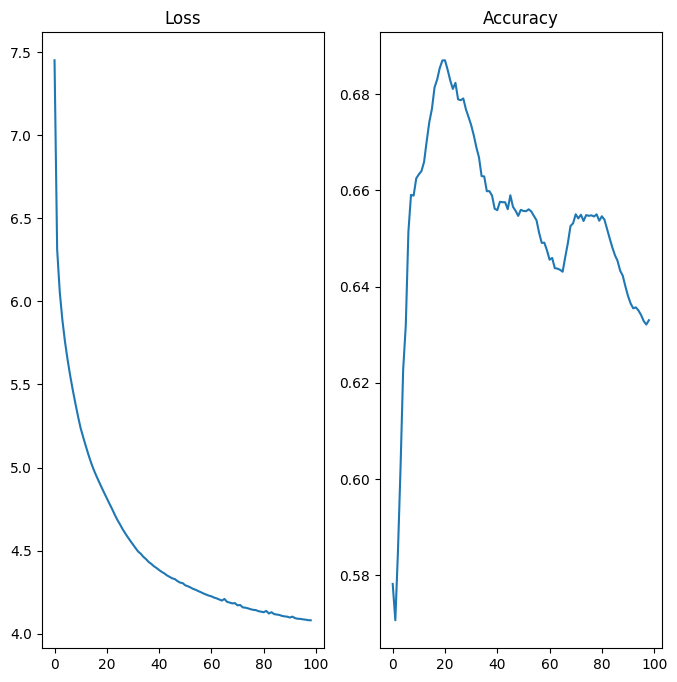

In [16]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Linear evaluation

In [17]:
start_time = datetime.now()
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=12,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    flag_use_multi_gpu=configs.flag_use_multi_gpu,
    after_epoch_callback=pretrain_callback,
)

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

start_logging(RANDOM_SEED, logging_directory)
val_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_val, y_val[:, 0])
print("Linear evaluation for validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_test, y_test[:, 0])
print("Linear evaluation for test set\n",test_metrics_dict)
print()
stop_logging()

Linear evaluation for validation set
 {'Accuracy': 0.5782312925170068, 'Precision': 0.6512169714936392, 'Recall': 0.6705207400266933, 'F1': 0.6330114271809446, 'AUROC': np.float64(0.8594332094723623), 'AUPRC': np.float64(0.6967008772369782)}
Linear evaluation for test set
 {'Accuracy': 0.5730624529721595, 'Precision': 0.6704560522305336, 'Recall': 0.6700840005893743, 'F1': 0.6441107212759124, 'AUROC': np.float64(0.8633589889530663), 'AUPRC': np.float64(0.7080020714491646)}

torch.Size([128, 4])
torch.Size([128, 4])


## Full fine-tuning

In [14]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=12, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=4, device=device, flag_use_multi_gpu=False)

In [16]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_100, finetune_epochs=configs.finetune_epochs_100, num_classes=4, finetune_lr=configs.finetune_lr_100, fraction=configs.fraction_100, device=device, callback=finetune_callback)

100%|██████████| 645/645 [00:18<00:00, 33.97it/s]


Epoch number: 0
Loss: 0.7652595801408901
{'Accuracy': 0.6502926752096188, 'Precision': 0.7535699525855414, 'Recall': 0.7272672306890989, 'F1': 0.7062905591964295, 'AUROC': np.float64(0.9022453721103558), 'AUPRC': np.float64(0.7960091011871699)}


100%|██████████| 645/645 [00:19<00:00, 33.88it/s]


Epoch number: 1
Loss: 0.5519921061604522
{'Accuracy': 0.587327954437589, 'Precision': 0.702470032143915, 'Recall': 0.6946625963557773, 'F1': 0.6467376291524999, 'AUROC': np.float64(0.8825794512271659), 'AUPRC': np.float64(0.763848142857012)}


100%|██████████| 645/645 [00:19<00:00, 32.74it/s]


Epoch number: 2
Loss: 0.453382079064538
{'Accuracy': 0.5971365290302167, 'Precision': 0.7272524025626201, 'Recall': 0.7122282735626944, 'F1': 0.6430514291639806, 'AUROC': np.float64(0.8722190837606747), 'AUPRC': np.float64(0.7480124701209278)}


100%|██████████| 645/645 [00:19<00:00, 32.40it/s]


Epoch number: 3
Loss: 0.3952332312775444
{'Accuracy': 0.586062331909508, 'Precision': 0.7408452601898209, 'Recall': 0.7036031395737068, 'F1': 0.6244265559682325, 'AUROC': np.float64(0.8367394436658078), 'AUPRC': np.float64(0.7083802814615274)}


100%|██████████| 645/645 [00:19<00:00, 32.87it/s]


Epoch number: 4
Loss: 0.3576572907664055
{'Accuracy': 0.5950798924220851, 'Precision': 0.7386581588109395, 'Recall': 0.7143488570027021, 'F1': 0.631773410751162, 'AUROC': np.float64(0.8733780550414256), 'AUPRC': np.float64(0.7464821761004629)}


100%|██████████| 645/645 [00:19<00:00, 33.04it/s]


Epoch number: 5
Loss: 0.33028265054912836
{'Accuracy': 0.5944470811580446, 'Precision': 0.7268640630555174, 'Recall': 0.7146351012483536, 'F1': 0.6332595933498109, 'AUROC': np.float64(0.8646257662465648), 'AUPRC': np.float64(0.7357954477771109)}


100%|██████████| 645/645 [00:19<00:00, 32.79it/s]


Epoch number: 6
Loss: 0.3071743721994319
{'Accuracy': 0.5914412276538522, 'Precision': 0.7257202016224729, 'Recall': 0.714123701931914, 'F1': 0.6251183472443421, 'AUROC': np.float64(0.8554299387100651), 'AUPRC': np.float64(0.7254725066069205)}


100%|██████████| 645/645 [00:19<00:00, 32.77it/s]


Epoch number: 7
Loss: 0.28821867089862974
{'Accuracy': 0.5877234614776143, 'Precision': 0.7355925434233616, 'Recall': 0.7050279391315378, 'F1': 0.6282664200844419, 'AUROC': np.float64(0.8608097987781969), 'AUPRC': np.float64(0.7358564777528925)}


100%|██████████| 645/645 [00:19<00:00, 32.88it/s]


Epoch number: 8
Loss: 0.2729547965408501
{'Accuracy': 0.5942888783420345, 'Precision': 0.7326325292601779, 'Recall': 0.7137407457791424, 'F1': 0.6338206691489443, 'AUROC': np.float64(0.8759561430074143), 'AUPRC': np.float64(0.7598717871951638)}


100%|██████████| 645/645 [00:19<00:00, 32.86it/s]


Epoch number: 9
Loss: 0.2610207248687051
{'Accuracy': 0.5915203290618573, 'Precision': 0.7319044137060243, 'Recall': 0.711963953223811, 'F1': 0.6270883359144537, 'AUROC': np.float64(0.8600312303050843), 'AUPRC': np.float64(0.7380533251728078)}


100%|██████████| 645/645 [00:19<00:00, 33.21it/s]


Epoch number: 10
Loss: 0.2491710050728558
{'Accuracy': 0.5726941939566524, 'Precision': 0.7013295035833831, 'Recall': 0.690663237554119, 'F1': 0.6058552271501161, 'AUROC': np.float64(0.8531927081456887), 'AUPRC': np.float64(0.7260854602279139)}


100%|██████████| 645/645 [00:19<00:00, 33.39it/s]


Epoch number: 11
Loss: 0.23889236521235732
{'Accuracy': 0.5370194589463693, 'Precision': 0.6944087018805247, 'Recall': 0.6449594843075086, 'F1': 0.5690446232583366, 'AUROC': np.float64(0.8462034130073078), 'AUPRC': np.float64(0.7208021742039084)}


100%|██████████| 645/645 [00:19<00:00, 33.45it/s]


Epoch number: 12
Loss: 0.23002177043398647
{'Accuracy': 0.5794969150450878, 'Precision': 0.693551264759822, 'Recall': 0.6940779344024929, 'F1': 0.6222307981561607, 'AUROC': np.float64(0.840594218380354), 'AUPRC': np.float64(0.7167466037793034)}


100%|██████████| 645/645 [00:19<00:00, 33.12it/s]


Epoch number: 13
Loss: 0.22173506206402746
{'Accuracy': 0.5938933713020091, 'Precision': 0.7096201388275478, 'Recall': 0.7089217541388525, 'F1': 0.6415372839220603, 'AUROC': np.float64(0.8576804887005703), 'AUPRC': np.float64(0.7281098448930987)}


100%|██████████| 645/645 [00:19<00:00, 33.02it/s]


Epoch number: 14
Loss: 0.21549523371731433
{'Accuracy': 0.5995886726783737, 'Precision': 0.6977198597662249, 'Recall': 0.7049488930376381, 'F1': 0.6485531860879141, 'AUROC': np.float64(0.8846487779672835), 'AUPRC': np.float64(0.7642425863236966)}


100%|██████████| 645/645 [00:19<00:00, 32.83it/s]


Epoch number: 15
Loss: 0.20866712765035386
{'Accuracy': 0.5786267995570321, 'Precision': 0.7003136900875349, 'Recall': 0.696887686293394, 'F1': 0.6114905699768665, 'AUROC': np.float64(0.8655985491297643), 'AUPRC': np.float64(0.7455575325276731)}


100%|██████████| 645/645 [00:19<00:00, 33.01it/s]


Epoch number: 16
Loss: 0.2029858766292675
{'Accuracy': 0.5902547065337763, 'Precision': 0.7255623940253628, 'Recall': 0.7042158887993885, 'F1': 0.63479911792465, 'AUROC': np.float64(0.879523398440792), 'AUPRC': np.float64(0.763709466218677)}


100%|██████████| 645/645 [00:19<00:00, 32.95it/s]


Epoch number: 17
Loss: 0.1970189073007926
{'Accuracy': 0.587248853029584, 'Precision': 0.6931748230869405, 'Recall': 0.7025943080327133, 'F1': 0.6326485336326648, 'AUROC': np.float64(0.8497969717819699), 'AUPRC': np.float64(0.7275130115758797)}


100%|██████████| 645/645 [00:19<00:00, 33.18it/s]


Epoch number: 18
Loss: 0.1914365636405578
{'Accuracy': 0.5773611770289511, 'Precision': 0.6934493128268693, 'Recall': 0.6897593658925584, 'F1': 0.6240328795710662, 'AUROC': np.float64(0.8528955559426913), 'AUPRC': np.float64(0.7331582699074721)}


100%|██████████| 645/645 [00:19<00:00, 32.86it/s]


Epoch number: 19
Loss: 0.18643492216753318
{'Accuracy': 0.5947634867900649, 'Precision': 0.7118544503665512, 'Recall': 0.7133042359629816, 'F1': 0.638423376919661, 'AUROC': np.float64(0.8562592325608418), 'AUPRC': np.float64(0.7355796503387115)}


100%|██████████| 645/645 [00:19<00:00, 32.96it/s]


Epoch number: 20
Loss: 0.18145924959240303
{'Accuracy': 0.589938300901756, 'Precision': 0.7031343404185533, 'Recall': 0.7039259388386366, 'F1': 0.6373719998879973, 'AUROC': np.float64(0.8370197169451263), 'AUPRC': np.float64(0.7272140662649041)}


100%|██████████| 645/645 [00:19<00:00, 32.74it/s]


Epoch number: 21
Loss: 0.17686020717634526
{'Accuracy': 0.574671729156779, 'Precision': 0.6768060251231982, 'Recall': 0.6860544711015367, 'F1': 0.6211522407560562, 'AUROC': np.float64(0.8316185271390435), 'AUPRC': np.float64(0.7105987567369857)}


100%|██████████| 645/645 [00:19<00:00, 32.98it/s]


Epoch number: 22
Loss: 0.17359811573543274
{'Accuracy': 0.5934187628539788, 'Precision': 0.7128872525671205, 'Recall': 0.7099374094014699, 'F1': 0.6362366211709811, 'AUROC': np.float64(0.8597249835506529), 'AUPRC': np.float64(0.7415565235426583)}


100%|██████████| 645/645 [00:19<00:00, 32.57it/s]


Epoch number: 23
Loss: 0.16970050835453132
{'Accuracy': 0.5890681854137003, 'Precision': 0.7012374944144774, 'Recall': 0.7019188166001796, 'F1': 0.6381832485290706, 'AUROC': np.float64(0.8536342047089907), 'AUPRC': np.float64(0.7276753880915183)}


100%|██████████| 645/645 [00:19<00:00, 32.98it/s]


Epoch number: 24
Loss: 0.16594434839264713
{'Accuracy': 0.5947634867900649, 'Precision': 0.7037321463633485, 'Recall': 0.7094972728404034, 'F1': 0.6365368725143279, 'AUROC': np.float64(0.8669993485024663), 'AUPRC': np.float64(0.7500534939699252)}


100%|██████████| 645/645 [00:19<00:00, 33.27it/s]


Epoch number: 25
Loss: 0.16235339684519065
{'Accuracy': 0.5971365290302167, 'Precision': 0.7196991002706317, 'Recall': 0.7134537291482101, 'F1': 0.64018046395359, 'AUROC': np.float64(0.8645135779197256), 'AUPRC': np.float64(0.7442556653715832)}


100%|██████████| 645/645 [00:19<00:00, 33.00it/s]


Epoch number: 26
Loss: 0.15887859518450698
{'Accuracy': 0.5923113431419079, 'Precision': 0.7401222771662711, 'Recall': 0.7129384219684559, 'F1': 0.6291644798500872, 'AUROC': np.float64(0.851657138881273), 'AUPRC': np.float64(0.7360432776639766)}


100%|██████████| 645/645 [00:19<00:00, 32.80it/s]


Epoch number: 27
Loss: 0.1557765629765725
{'Accuracy': 0.5977693402942572, 'Precision': 0.7460027440410857, 'Recall': 0.7180622732713062, 'F1': 0.6354107017063114, 'AUROC': np.float64(0.8473099103482178), 'AUPRC': np.float64(0.7344745499552411)}


100%|██████████| 645/645 [00:19<00:00, 33.13it/s]


Epoch number: 28
Loss: 0.15332857217125354
{'Accuracy': 0.5975320360702421, 'Precision': 0.7188162736815653, 'Recall': 0.7133714365792806, 'F1': 0.6415939960705074, 'AUROC': np.float64(0.8299619579432628), 'AUPRC': np.float64(0.7177049140207993)}


100%|██████████| 645/645 [00:19<00:00, 32.89it/s]


Epoch number: 29
Loss: 0.1504607746211297
{'Accuracy': 0.5989558614143332, 'Precision': 0.7288796596529212, 'Recall': 0.7125607954779991, 'F1': 0.643589873441703, 'AUROC': np.float64(0.8288670337898546), 'AUPRC': np.float64(0.7164502584333209)}


100%|██████████| 645/645 [00:19<00:00, 32.73it/s]


Epoch number: 30
Loss: 0.14767761175695618
{'Accuracy': 0.5771238728049359, 'Precision': 0.7092083658326436, 'Recall': 0.6939780594551925, 'F1': 0.6120775323427533, 'AUROC': np.float64(0.83618121304534), 'AUPRC': np.float64(0.7219261826295051)}


100%|██████████| 645/645 [00:19<00:00, 32.91it/s]


Epoch number: 31
Loss: 0.1449325678129852
{'Accuracy': 0.586062331909508, 'Precision': 0.714742434050087, 'Recall': 0.7034671517369898, 'F1': 0.6267471972684262, 'AUROC': np.float64(0.8317176007121267), 'AUPRC': np.float64(0.715283414793372)}


100%|██████████| 645/645 [00:19<00:00, 32.80it/s]


Epoch number: 32
Loss: 0.1423086552045424
{'Accuracy': 0.5806834361651637, 'Precision': 0.7391089979383474, 'Recall': 0.692360932788153, 'F1': 0.622607103443612, 'AUROC': np.float64(0.8445233188956349), 'AUPRC': np.float64(0.7346628153367012)}


100%|██████████| 645/645 [00:19<00:00, 32.83it/s]


Epoch number: 33
Loss: 0.13979994778277594
{'Accuracy': 0.5926277487739282, 'Precision': 0.7240786711933698, 'Recall': 0.7117060551231136, 'F1': 0.6312804579150545, 'AUROC': np.float64(0.8555635238054076), 'AUPRC': np.float64(0.7398603215443869)}


100%|██████████| 645/645 [00:19<00:00, 32.80it/s]


Epoch number: 34
Loss: 0.13740042324843152
{'Accuracy': 0.596266413542161, 'Precision': 0.7207271855508206, 'Recall': 0.7128420212451948, 'F1': 0.6391045933075434, 'AUROC': np.float64(0.808892185573436), 'AUPRC': np.float64(0.6956798046137882)}


100%|██████████| 645/645 [00:19<00:00, 32.81it/s]


Epoch number: 35
Loss: 0.13529339991664333
{'Accuracy': 0.596266413542161, 'Precision': 0.7323069258330897, 'Recall': 0.7163697680565398, 'F1': 0.6339755926259871, 'AUROC': np.float64(0.8328799232970998), 'AUPRC': np.float64(0.7178038444230568)}


100%|██████████| 645/645 [00:19<00:00, 33.24it/s]


Epoch number: 36
Loss: 0.13324756581276162
{'Accuracy': 0.5842429995253916, 'Precision': 0.6932095884483773, 'Recall': 0.6924632845607712, 'F1': 0.6386544690283034, 'AUROC': np.float64(0.8306367731825661), 'AUPRC': np.float64(0.7148017337542405)}


100%|██████████| 645/645 [00:19<00:00, 33.19it/s]


Epoch number: 37
Loss: 0.13141670757509474
{'Accuracy': 0.5980066445182725, 'Precision': 0.7180409693821312, 'Recall': 0.7156642894474361, 'F1': 0.6420236922498361, 'AUROC': np.float64(0.8383458522834495), 'AUPRC': np.float64(0.7262368096733942)}


100%|██████████| 645/645 [00:19<00:00, 32.88it/s]


Epoch number: 38
Loss: 0.1295968774385503
{'Accuracy': 0.596187312134156, 'Precision': 0.7148669869263701, 'Recall': 0.7144793696241964, 'F1': 0.6409548948591205, 'AUROC': np.float64(0.8520877061409723), 'AUPRC': np.float64(0.7371597167824568)}


100%|██████████| 645/645 [00:19<00:00, 32.93it/s]


Epoch number: 39
Loss: 0.1276597759467297
{'Accuracy': 0.5979275431102674, 'Precision': 0.7338951143103533, 'Recall': 0.7209547993977103, 'F1': 0.6334836214583, 'AUROC': np.float64(0.853640326167735), 'AUPRC': np.float64(0.7329407455759039)}


100%|██████████| 645/645 [00:19<00:00, 32.74it/s]


Epoch number: 40
Loss: 0.12585743691653892
{'Accuracy': 0.5958709065021357, 'Precision': 0.7444513530752845, 'Recall': 0.7181256430331341, 'F1': 0.6318580619077478, 'AUROC': np.float64(0.8439738942133989), 'AUPRC': np.float64(0.7344861370909004)}


100%|██████████| 645/645 [00:19<00:00, 33.03it/s]


Epoch number: 41
Loss: 0.12399987184164799
{'Accuracy': 0.5975320360702421, 'Precision': 0.7336315648148354, 'Recall': 0.7178587689891256, 'F1': 0.636492337817066, 'AUROC': np.float64(0.8501040570917855), 'AUPRC': np.float64(0.7455582077994934)}


100%|██████████| 645/645 [00:19<00:00, 33.31it/s]


Epoch number: 42
Loss: 0.12224098255663737
{'Accuracy': 0.5956336022781206, 'Precision': 0.7204956795379067, 'Recall': 0.717436878259295, 'F1': 0.6336047461040495, 'AUROC': np.float64(0.8322307556923805), 'AUPRC': np.float64(0.7195814506051669)}


100%|██████████| 645/645 [00:19<00:00, 33.21it/s]


Epoch number: 43
Loss: 0.12061608489835798
{'Accuracy': 0.6033855402626167, 'Precision': 0.7291754898301672, 'Recall': 0.7206364439869367, 'F1': 0.6482497926942443, 'AUROC': np.float64(0.860702141437329), 'AUPRC': np.float64(0.7462949583378635)}


100%|██████████| 645/645 [00:19<00:00, 33.20it/s]


Epoch number: 44
Loss: 0.11896480383770179
{'Accuracy': 0.5880398671096345, 'Precision': 0.7106391183241719, 'Recall': 0.7069222071550394, 'F1': 0.629536410489045, 'AUROC': np.float64(0.827079503840936), 'AUPRC': np.float64(0.7188738557590021)}


100%|██████████| 645/645 [00:19<00:00, 32.79it/s]


Epoch number: 45
Loss: 0.11749292071801988
{'Accuracy': 0.602515424774561, 'Precision': 0.7164191449495358, 'Recall': 0.7194661520761079, 'F1': 0.6494438976150944, 'AUROC': np.float64(0.8474079566425435), 'AUPRC': np.float64(0.7355799001457106)}


100%|██████████| 645/645 [00:19<00:00, 32.91it/s]


Epoch number: 46
Loss: 0.11627873820938574
{'Accuracy': 0.6060749881347888, 'Precision': 0.7185397399321994, 'Recall': 0.7214796004981545, 'F1': 0.6494162932463583, 'AUROC': np.float64(0.8666478068265642), 'AUPRC': np.float64(0.7499996048647564)}


100%|██████████| 645/645 [00:19<00:00, 32.78it/s]


Epoch number: 47
Loss: 0.11527346263068683
{'Accuracy': 0.5953962980541053, 'Precision': 0.7254842789862744, 'Recall': 0.7183610485126248, 'F1': 0.6302659388787758, 'AUROC': np.float64(0.8176308016892964), 'AUPRC': np.float64(0.7031383798004547)}


100%|██████████| 645/645 [00:19<00:00, 33.02it/s]


Epoch number: 48
Loss: 0.11422390735311397
{'Accuracy': 0.593735168485999, 'Precision': 0.7070955150335597, 'Recall': 0.7130891998903629, 'F1': 0.6333006427768488, 'AUROC': np.float64(0.8326936560313583), 'AUPRC': np.float64(0.7149204408295176)}


100%|██████████| 645/645 [00:19<00:00, 33.04it/s]


Epoch number: 49
Loss: 0.1129148201488767
{'Accuracy': 0.5931023572219586, 'Precision': 0.7081169653794874, 'Recall': 0.7139927902012491, 'F1': 0.6342076343509515, 'AUROC': np.float64(0.8393162804847341), 'AUPRC': np.float64(0.7285207910054882)}


In [15]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_100}_scratch_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_100} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_100} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

Finetune for 1.0 fraction of validation set
{'Accuracy': 0.6502926752096188, 'Precision': 0.7535699525855414, 'Recall': 0.7272672306890989, 'F1': 0.7062905591964295, 'AUROC': np.float64(0.9022453209638782), 'AUPRC': np.float64(0.7960094678573981)}
Finetune for 1.0 fraction of test set
{'Accuracy': 0.671030850263356, 'Precision': 0.7814041946869885, 'Recall': 0.7552879564861079, 'F1': 0.7346390120600477, 'AUROC': np.float64(0.9255148982195629), 'AUPRC': np.float64(0.8388610255854196)}



In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Semi-supervised

### 10% label

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

In [ ]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_10,finetune_epochs=configs.finetune_epochs_10, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_10, fraction=configs.fraction_10, device=device, callback=finetune_callback)

In [ ]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_10}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_10} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_10} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 1% label

In [ ]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

In [ ]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=configs.finetune_epochs_1, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_1, fraction=configs.fraction_1, device=device, callback=finetune_callback)

In [ ]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_1}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_1} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_1} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

In [ ]:
end_time = datetime.now()
print(f'Duration: {end_time - start_time}')